### Imports

In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

In [2]:
import numpy as np
import umap
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

In [3]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

### Device

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Constants

In [5]:
BATCH_SIZE = 32
INPUT_SIZE = 1
NUM_EPOCHS = 10
KERNEL_SIZE = 3

### Load and split data

In [6]:
digits = load_digits()

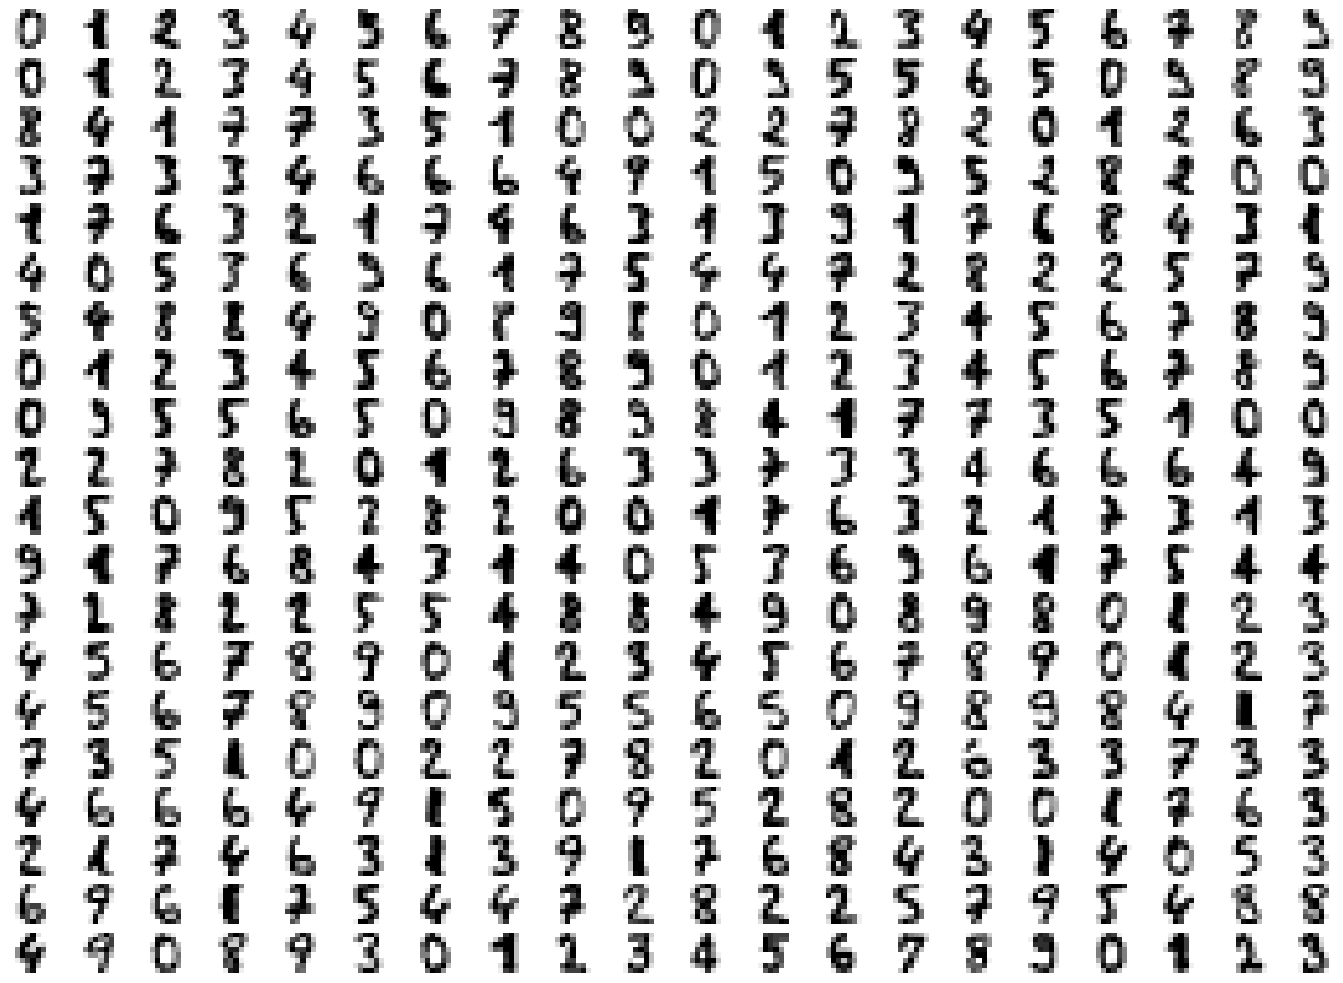

In [7]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [8]:
reducer = umap.UMAP(random_state=42, n_jobs=1)
reducer.fit(digits.data)

UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [9]:
embedding = reducer.transform(digits.data)

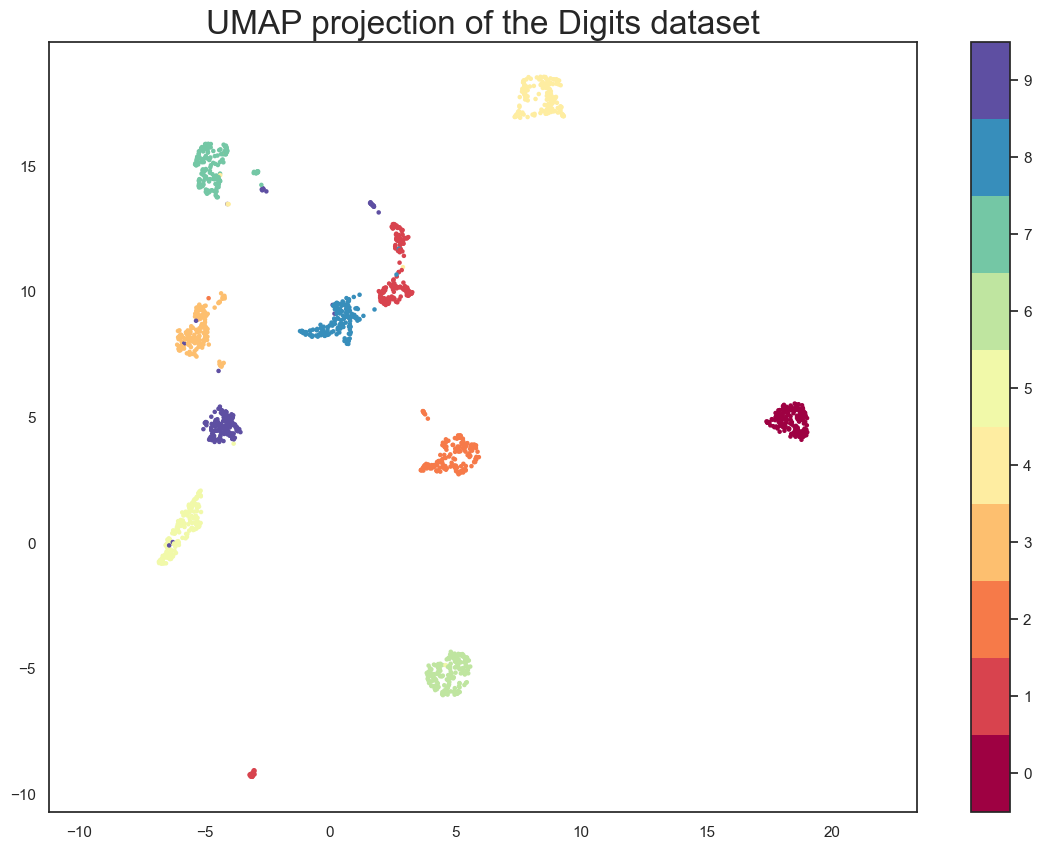

In [10]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [11]:
X, y_primary = digits.data, digits.target

In [12]:
X_3 = X[y_primary == 3]

In [13]:
X_8 = X[y_primary == 8]

In [14]:
X_9 = X[y_primary == 9]

In [15]:
X_secondary = []
for idx, label in enumerate(y_primary):
    if label in (3, 8, 9):
        X_secondary.append(X[idx])
    elif label in (1, 5, 6):
        X_secondary.append(X_3[np.random.choice(X_3.shape[0])] + (np.random.random() - 0.5) * 0.16 / 0.5)
    elif label in (0, 2):
        X_secondary.append(X_9[np.random.choice(X_9.shape[0])] + (np.random.random() - 0.5) * 0.16 / 0.5)
    else:
        X_secondary.append(X_8[np.random.choice(X_8.shape[0])] + (np.random.random() - 0.5) * 0.16 / 0.5)
        
X_secondary = np.array(X_secondary)

In [16]:
y_secondary_lebeled = np.array([3 if label in (1, 3, 5, 6)
               else 9 if label in (0, 2, 9)
               else 8 for label in y_primary])
y_secondary_mislabeled = np.array([3 if label in (0, 3, 5, 6)
               else 9 if label in (1, 2, 9)
               else 8 for label in y_primary])

In [17]:
lb = LabelBinarizer()
lb.fit(y_secondary_mislabeled)
y = lb.transform(y_secondary_mislabeled)
classes = lb.classes_

In [18]:
X_training, X_test, y_training, y_test = train_test_split(X_secondary, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, stratify=y_training)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Custom dataset

In [20]:
class DigitsDataset(Dataset):
    def __init__(self, samples, labels):
        """        
        Args:
            samples: An array of time series, first dimension is time steps
            labels: An array of surface labels
        """

        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single, windowed time series from dataset
        """
        
        X = self.samples[idx]
        y = self.labels[idx]
        
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)
    
train_dataloader = DataLoader(DigitsDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(DigitsDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(DigitsDataset(X_test, y_test), batch_size=1)

### Models

In [21]:
class CNNDigitsClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None, kernel_size=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        
        self.fc_pre = nn.Sequential(
            nn.Conv1d(self.input_size, 32, 7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )
        self.blocks = nn.Sequential(
            nn.Conv1d(32, 64, self.kernel_size, stride=2, padding=1), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc_post = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(512, self.output_size),
        )

    def forward(self, x):
        x = self.fc_pre(x)
        x = self.blocks(x)
        return self.fc_post(x)

cnn_model = CNNDigitsClassifier(input_size=INPUT_SIZE, output_size=3, kernel_size=KERNEL_SIZE).to(device)

In [22]:
summary(cnn_model)

Layer (type:depth-idx)                   Param #
CNNDigitsClassifier                      --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       256
│    └─BatchNorm1d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool1d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-5                       6,208
│    └─BatchNorm1d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─Conv1d: 2-8                       24,704
│    └─BatchNorm1d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      98,560
│    └─BatchNorm1d: 2-12                 512
│    └─ReLU: 2-13                        --
│    └─Conv1d: 2-14                      393,728
│    └─BatchNorm1d: 2-15                 1,024
│    └─ReLU: 2-16                        --
├─Sequential: 1-3                        --
│    └─AdaptiveAvgPool1d: 2-17           --
│   

### Loss function

In [23]:
criterion = nn.CrossEntropyLoss()

### Optimizer

In [24]:
optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=1e-3,
    eps=1e-6,
    weight_decay=1e-3,
    )
scheduler = ExponentialLR(optimizer, gamma=0.9)

### Early stopping

In [25]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3, min_delta=1e-3)

### Training loop

In [26]:
train_batches = len(train_dataloader)
val_batches = len(val_dataloader)

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    pbar = tqdm(train_dataloader, total=train_batches)
    cnn_model.train()
    for idx, (batch_x, batch_y) in enumerate(pbar):
        optimizer.zero_grad()
        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = torch.unsqueeze(batch_x, 1)
        train_outputs = cnn_model(batch_x)
        train_loss = criterion(train_outputs, batch_y)
        running_train_loss += train_loss

        # Backward pass
        train_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training loss: {running_train_loss / (idx + 1):.2E}")
    scheduler.step()

    pbar_val = tqdm(val_dataloader, total=val_batches)
    cnn_model.eval()
    with torch.no_grad():
        for idx, (batch_x_val, batch_y_val) in enumerate(pbar_val):
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            batch_x_val = torch.unsqueeze(batch_x_val, 1)
            val_outputs = cnn_model(batch_x_val)
            val_loss = criterion(val_outputs, batch_y_val)
            running_val_loss += val_loss
            
            pbar_val.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Validation loss: {running_val_loss / (idx + 1):.2E}")
            
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': running_train_loss,
        'val_loss': running_val_loss,
    }, f"../data/checkpoints/cnn_classifier_{epoch + 1}.pt")

Epoch 10/10, Validation loss: 7.72E-01: 100%|██████████| 9/9 [00:00<00:00, 237.48it/s]


### Test

In [27]:
test_batches = len(test_dataloader)
y_pred = []
running_test_loss = 0.0

pbar_test = tqdm(test_dataloader, total=test_batches)
cnn_model.eval()
with torch.no_grad():
    for idx, (batch_x_test, batch_y_test) in enumerate(pbar_test):
        batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
        batch_x_test = torch.unsqueeze(batch_x_test, 1)
        test_outputs = cnn_model(batch_x_test)
        test_loss = criterion(test_outputs, batch_y_test)
        pred = torch.argmax(test_outputs).cpu().numpy().item()
        y_pred.append(classes[pred])
        running_test_loss += test_loss
        
        pbar_test.set_description(f"Test loss: {running_test_loss / (idx + 1):.2E}")

Test loss: 8.30E-01: 100%|██████████| 360/360 [00:01<00:00, 240.33it/s]


### Confusion matrix

              precision    recall  f1-score   support

           3       0.64      0.67      0.65       145
           8       1.00      1.00      1.00       107
           9       0.52      0.49      0.51       108

    accuracy                           0.71       360
   macro avg       0.72      0.72      0.72       360
weighted avg       0.71      0.71      0.71       360


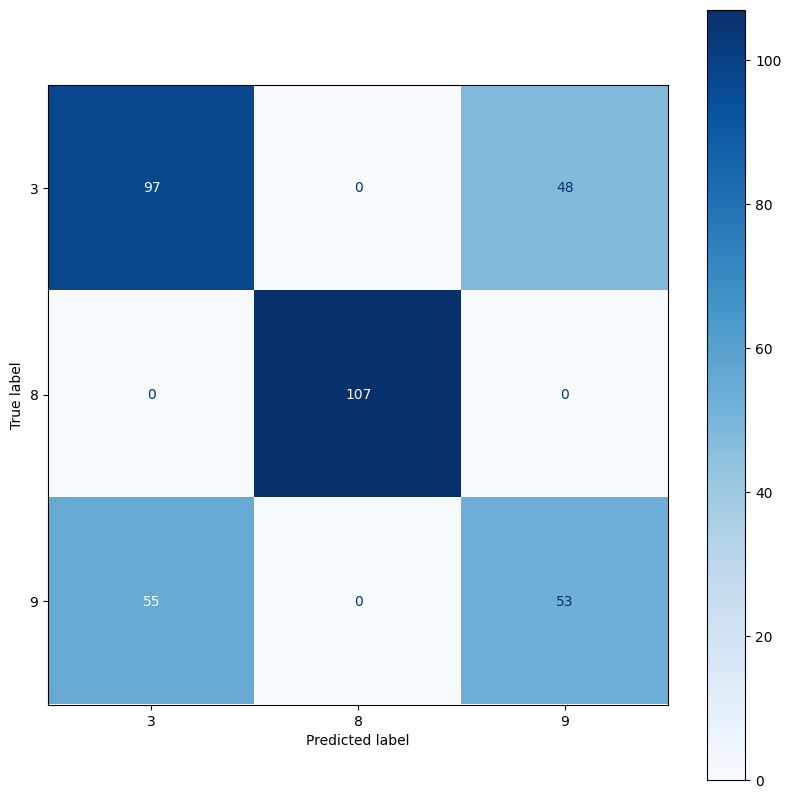

In [28]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

y_test = lb.inverse_transform(y_test)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax)